In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
import cv2
print(torch.__version__, torch.cuda.is_available())
# !gcc --version
# opencv is pre-installed on colab

# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
# assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime
# Or, to install it from a local clone:
!git clone https://github.com/facebookresearch/detectron2.git
!python -m pip install -e detectron2

# Some basic setup:
# Setup detectron2 logger


     |████████████████████████████████| 274 kB 5.4 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=0a7ec9489c1b5643282a9f6d2b9c6aa0d6c2a946acc90b3f57731633a3be564f
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.10.0+cu111 True
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.3 MB 794 kB/s 
     |████████████████████████████████| 74 kB 2.1 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 145 kB 11.1 MB/s 
     |████████████████████████████████| 130 kB 47.8 MB/s 
     |████████████████████████████████| 843 kB 39.3 MB/s 
     |████████████████████████████████| 749 kB 4

Cloning into 'detectron2'...
remote: Enumerating objects: 13638, done.
remote: Counting objects: 100% (1139/1139), done.
remote: Compressing objects: 100% (610/610), done.
remote: Total 13638 (delta 715), reused 865 (delta 520), pack-reused 12499
Receiving objects: 100% (13638/13638), 5.83 MiB | 17.77 MiB/s, done.
Resolving deltas: 100% (9663/9663), done.
Obtaining file:///content/detectron2
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6+cu101
    Uninstalling detectron2-0.6+cu101:
      Successfully uninstalled detectron2-0.6+cu101
  Running setup.py develop for detectron2


In [ ]:
# import some common libraries
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


In [ ]:
!unzip hushem100_mhsma100.zip > /dev/null


In [ ]:
from google.colab.patches import cv2_imshow 
# im = cv2.imread("/content//amorphous_0.png")
# cv2_imshow(im)

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("hushem100_mhsma100", {}, "hushem100_mhsma100.json", 'hushem100_mhsma100')

mhsma_metadata = MetadataCatalog.get("hushem100_mhsma100")
dataset_dicts = DatasetCatalog.get("hushem100_mhsma100")

[11/27 15:49:49 d2.data.datasets.coco]: Loaded 200 images in COCO format from hushem100_mhsma100.json


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("hushem100_mhsma100")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025 
cfg.SOLVER.MAX_ITER = 6000 
cfg.SOLVER.STEPS = []      
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("hushem100_mhsma100", )
predictor = DefaultPredictor(cfg)


[11/27 15:50:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:06, 26.0MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

[11/27 15:50:16 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/27 15:50:57 d2.utils.events]:  eta: 3:30:22  iter: 19  total_loss: 2.752  loss_cls: 1.092  loss_box_reg: 0.827  loss_mask: 0.6995  loss_rpn_cls: 0.1014  loss_rpn_loc: 0.0151  time: 2.0533  data_time: 0.0352  lr: 4.9953e-06  max_mem: 5289M
[11/27 15:51:38 d2.utils.events]:  eta: 3:30:07  iter: 39  total_loss: 2.674  loss_cls: 0.9802  loss_box_reg: 0.8634  loss_mask: 0.6902  loss_rpn_cls: 0.06496  loss_rpn_loc: 0.01296  time: 2.0408  data_time: 0.0233  lr: 9.9902e-06  max_mem: 5289M
[11/27 15:52:19 d2.utils.events]:  eta: 3:29:48  iter: 59  total_loss: 2.503  loss_cls: 0.8202  loss_box_reg: 0.9339  loss_mask: 0.6691  loss_rpn_cls: 0.07722  loss_rpn_loc: 0.01757  time: 2.0506  data_time: 0.0228  lr: 1.4985e-05  max_mem: 5289M
[11/27 15:53:01 d2.utils.events]:  eta: 3:28:57  iter: 79  total_loss: 2.346  loss_cls: 0.6912  loss_box_reg: 0.9019  loss_mask: 0.6417  loss_rpn_cls: 0.07401  loss_rpn_loc: 0.01489  time: 2.0553  data_time: 0.0240  lr: 1.998e-05  max_mem: 5289M
[11/27 15:53:42 d

In [ ]:
evaluator = COCOEvaluator("hushem100_mhsma100", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "hushem100_mhsma100")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

[11/27 19:15:04 d2.data.datasets.coco]: Loaded 200 images in COCO format from hushem100_mhsma100.json
[11/27 19:15:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/27 19:15:04 d2.data.common]: Serializing 200 elements to byte tensors and concatenating them all ...
[11/27 19:15:04 d2.data.common]: Serialized dataset takes 0.07 MiB
[11/27 19:15:04 d2.evaluation.evaluator]: Start inference on 200 batches
[11/27 19:15:08 d2.evaluation.evaluator]: Inference done 11/200. Dataloading: 0.0016 s/iter. Inference: 0.2947 s/iter. Eval: 0.0007 s/iter. Total: 0.2969 s/iter. ETA=0:00:56
[11/27 19:15:13 d2.evaluation.evaluator]: Inference done 28/200. Dataloading: 0.0020 s/iter. Inference: 0.2955 s/iter. Eval: 0.0006 s/iter. Total: 0.2985 s/iter. ETA=0:00:51
[11/27 19:15:18 d2.evaluation.evaluator]: Inference done 45/200. Dataloading: 0.0024 s/iter. Inference: 0.2963 s/iter. Eval: 0

In [ ]:
def getMasksOfWantedClass(outputs, label):
  predicted_classes = outputs['instances'].pred_classes
  predicted_classes = predicted_classes.to('cpu').tolist()
  is_wanted_class = [x==label for x in predicted_classes]

  masks = outputs['instances'].pred_masks[is_wanted_class]
  masks  = masks.to('cpu').numpy()
  return masks

def showMasks(masks, scale=255):
  for m in masks:
    cv2_imshow(m)

def saveMasks(masks, scale=1, prefix = "./bin_masks/mask"):
  i = 1
  for m in masks:
    filename = prefix + str(i) + ".png"
    cv2.imwrite(filename, m*scale)

pyriform_50.png


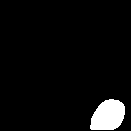

pyriform_54.png


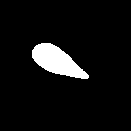

pyriform_6.png


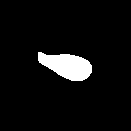

pyriform_20.png


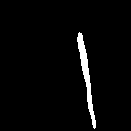

pyriform_45.png


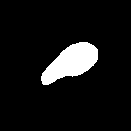

pyriform_4.png


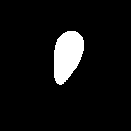

pyriform_3.png


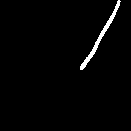

pyriform_47.png


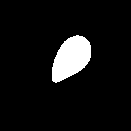

pyriform_25.png


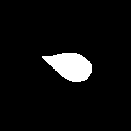

pyriform_55.png


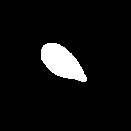

pyriform_1.png


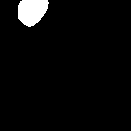

pyriform_42.png


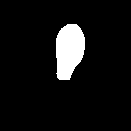

pyriform_37.png


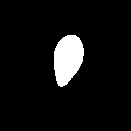

pyriform_7.png


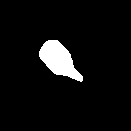

pyriform_22.png


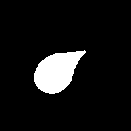

pyriform_16.png


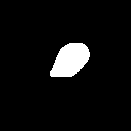

pyriform_17.png


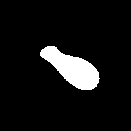

pyriform_15.png


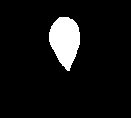

pyriform_41.png


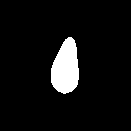

pyriform_36.png


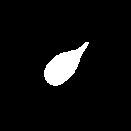

pyriform_5.png


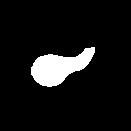

pyriform_39.png


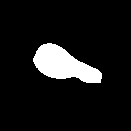

pyriform_18.png


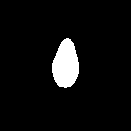

pyriform_10.png


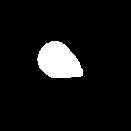

pyriform_44.png


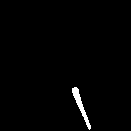

pyriform_12.png


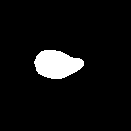

pyriform_33.png


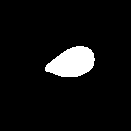

pyriform_26.png


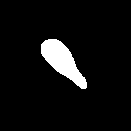

pyriform_29.png


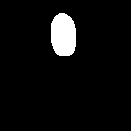

pyriform_28.png


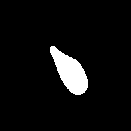

pyriform_51.png


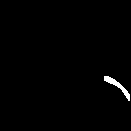

pyriform_2.png


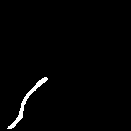

pyriform_9.png


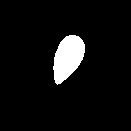

pyriform_56.png


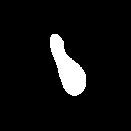

pyriform_46.png


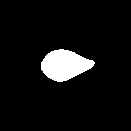

pyriform_53.png


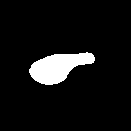

pyriform_35.png


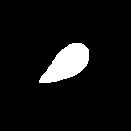

pyriform_48.png


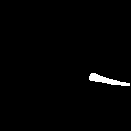

pyriform_52.png


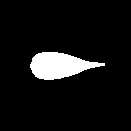

pyriform_31.png


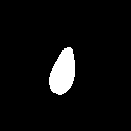

pyriform_30.png


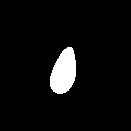

pyriform_32.png


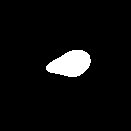

pyriform_38.png


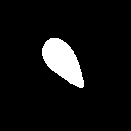

pyriform_8.png


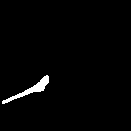

pyriform_21.png


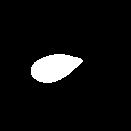

pyriform_23.png


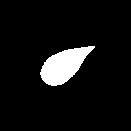

pyriform_14.png


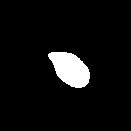

pyriform_49.png


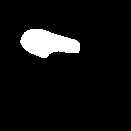

pyriform_0.png


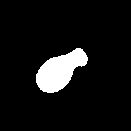

pyriform_11.png


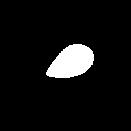

pyriform_19.png


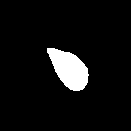

pyriform_43.png


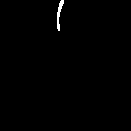

pyriform_40.png


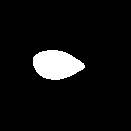

pyriform_13.png


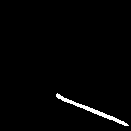

pyriform_24.png


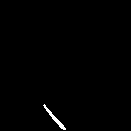

pyriform_34.png


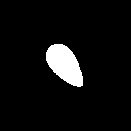

pyriform_27.png


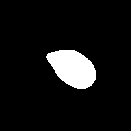

In [ ]:
import cv2
import os
from detectron2.utils.visualizer import ColorMode
i=0
photos = os.listdir('/content/pyrioform')
for photo in [p for p in photos if p.endswith('.png')]:
  i+=1
  path = f'/content/pyrioform/{photo}'
  print(photo)
  im = cv2.imread(path)
  cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
  predictor = DefaultPredictor(cfg)
  outputs = predictor(im)
  v = Visualizer(im[:,:,::-1], metadata=mhsma_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
   # cv2.imwrite(f'/content/amorphous/wyniki/wynik_hushem100_invicta150_mhsma100{i}.png', out.get_image()[:, :, ::-1])
  mask_array = outputs['instances'].pred_masks.to("cpu").numpy()
  num_instances = mask_array.shape[0]
  scores = outputs['instances'].scores.to("cpu").numpy()
  labels = outputs['instances'].pred_classes.to("cpu").numpy()
  bbox   = outputs['instances'].pred_boxes.to("cpu").tensor.numpy()

  mask_array = np.moveaxis(mask_array, 0, -1)

  mask_array_instance = []
  #img = np.zeros_like(im) #black
  h = im.shape[0]
  w = im.shape[1]
  img_mask = np.zeros([h, w, 3], np.uint8)
  color = (255, 255, 255)
  for j in np.nditer(labels):
    if j == 0:
      for i in range(1):
          img = np.zeros_like(im)
          mask_array_instance.append(mask_array[:, :, i:(i+1)])
          img = np.where(mask_array_instance[i] == True, 255, img)
          array_img = np.asarray(img)
          img_mask[np.where((array_img==[255,255,255]).all(axis=2))]=color
  
      
  img_mask = np.asarray(img_mask)
  output = cv2.addWeighted(im, 0.7, img_mask, 0.3, 0)
  cv2.imwrite(f'/content/pyrioform/wyniki/{photo}.png', img_mask)
  cv2_imshow(img_mask)
  
  # print(labels[1])

In [ ]:
!zip -r '/content/pyrioform/wyniki/"wynikitapered"' '/content/pyrioform/wyniki'

  adding: content/pyrioform/wyniki/ (stored 0%)
  adding: content/pyrioform/wyniki/pyriform_39.png.png (deflated 29%)
  adding: content/pyrioform/wyniki/pyriform_54.png.png (deflated 33%)
  adding: content/pyrioform/wyniki/pyriform_22.png.png (deflated 32%)
  adding: content/pyrioform/wyniki/pyriform_53.png.png (deflated 34%)
  adding: content/pyrioform/wyniki/pyriform_38.png.png (deflated 24%)
  adding: content/pyrioform/wyniki/pyriform_27.png.png (deflated 34%)
  adding: content/pyrioform/wyniki/pyriform_21.png.png (deflated 39%)
  adding: content/pyrioform/wyniki/pyriform_28.png.png (deflated 26%)
  adding: content/pyrioform/wyniki/pyriform_33.png.png (deflated 37%)
  adding: content/pyrioform/wyniki/pyriform_32.png.png (deflated 39%)
  adding: content/pyrioform/wyniki/pyriform_10.png.png (deflated 37%)
  adding: content/pyrioform/wyniki/pyriform_3.png.png (deflated 27%)
  adding: content/pyrioform/wyniki/pyriform_17.png.png (deflated 30%)
  adding: content/pyrioform/wyniki/pyriform

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('gdrive')
# !cp /content/output/* gdrive/'My Drive'/output/*
!cp /content/output/model_final.pth gdrive/'My Drive'/model_final.pth
!cp /content/output/instances_predictions.pth gdrive/'My Drive'/instances_predictions.pth
!cp /content/output/coco_instances_results.json gdrive/'My Drive'/coco_instances_results.json
!cp /content/output/events.out.tfevents.1637848179.a15d66e95ab2.458.0 gdrive/'My Drive'/events.out.tfevents.1637848179.a15d66e95ab2.458.0

!cp /content/output/last_checkpoint gdrive/'My Drive'/last_checkpoint
!cp /content/output/metrics.json gdrive/'My Drive'/metrics.json
!cp /content/output/model_0004999.pth gdrive/'My Drive'/model_0004999.pth.json



Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).
